## <b>Import Pytorch and other libraries</b>

In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt

import io
import os

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
#Related to activation function
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
#import torchvision
from torchvision import datasets, models, transforms

import time
import os
import copy

### <b>Download and explore the dataset</b>

About the dataset: The grapevine leaf dataset consists of healthy leaves and unhealthy leaves affected by the Esca disease. There are 500 images within dataset. The dataset has the following folders:

/Ak<br>
/Nazli<br>
/Dimnit<br>
/Buzgulu<br>
/Ala_Idris<br><br>

The dataset is downloaded from the https://www.muratkoklu.com/en/publications/ website.

In [2]:
main_path = 'Grapevine_Leaves_Image_Dataset/'
path_Ak = main_path + 'Ak'
path_Ala_Idris = main_path + 'Ala_Idris'
path_Buzgulu = main_path + 'Buzgulu'
path_Dimnit = main_path + 'Dimnit'
path_Nazli = main_path + 'Nazli'

In [3]:
# Create an empty dataframe
main_df = pd.DataFrame()
# Concatenate list of 
main_df['images'] = os.listdir(path_Ak) + os.listdir(path_Ala_Idris) + os.listdir(path_Buzgulu) + os.listdir(path_Dimnit) + os.listdir(path_Nazli)

### After downloading the dataset there are 500 images within dataset.

In [4]:
# Select necessary fields
# Initialize empty lists
classes = []
paths = []
#Iterate to find the class and image associated
for image in main_df['images']:
    class_ = image.split(' (')[0]
    classes.append(class_)
    paths.append(main_path+class_+'/'+image)
main_df['classes'] = classes
main_df['path'] = paths   

In [5]:
# List top 3 records
main_df.head(3)

,images,classes,path
0,Ak (8).png,Ak,Grapevine_Leaves_Image_Dataset/Ak/Ak (8).png
1,Ak (79).png,Ak,Grapevine_Leaves_Image_Dataset/Ak/Ak (79).png
2,Ak (96).png,Ak,Grapevine_Leaves_Image_Dataset/Ak/Ak (96).png


## Count of each class

In [6]:
# Count in each of the 5 classes
main_df['classes'].value_counts()

Ak           100
Ala_Idris    100
Buzgulu      100
Dimnit       100
Nazli        100
Name: classes, dtype: int64

## Show image from each class

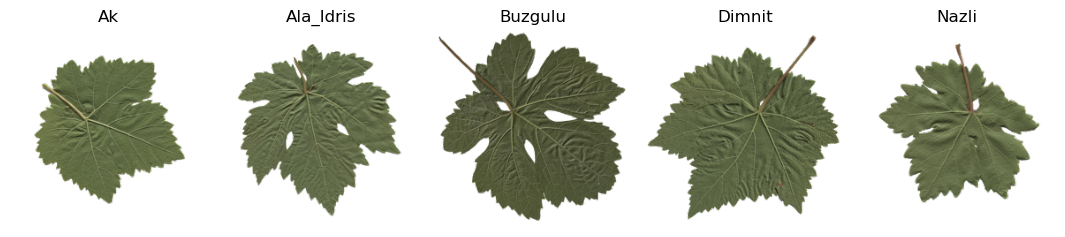

In [7]:
plt.figure(figsize = (15,12))
for idx,i in enumerate(main_df.classes.unique()):
    plt.subplot(4,7,idx+1)
    df = main_df[main_df['classes'] ==i]
    image_path = df.sample()['path'].values[0]
    img = Image.open(image_path)
    img = img.resize((224,224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
plt.tight_layout()
plt.show()

In [8]:
# Get unique names of classes
labelArr = main_df['classes'].unique()
# Dictionary to map numerical labels and classes
label2id = {}
id2label = {}
index = 0
for  class_name in labelArr:
    label2id[class_name] = str(index)
    id2label[str(index)] = class_name
    index=index +1
print(label2id)

{'Ak': '0', 'Ala_Idris': '1', 'Buzgulu': '2', 'Dimnit': '3', 'Nazli': '4'}


## Step 2. Split this data between 80% training and 20% test

In [9]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(main_df[['path', 'classes']], test_size=0.20, random_state =0)
print(len(train))
print(len(valid))

400
100


In [10]:
# Define class 
class GrapevineDataset(Dataset):
    # Initialize the dataset and check if train or val
    def __init__(self, dataframe, is_train, transform=None):
        self.dataframe = dataframe
        self.is_train = is_train 
        self.transform = transform
    # No of samples in dataset
    def __len__(self):
        return len(self.dataframe)
    # If train then reads from predefined dictionary
    # else sets to 1
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.dataframe['path'].iloc[idx]
        image = Image.open(img_path).convert('RGB') 
        
        if self.is_train:
            labelKey = self.dataframe['classes'].iloc[idx]
            label = torch.tensor(int(label2id[labelKey]))
            
        else:
            label =torch.tensor(1)

        if self.transform:
            image = self.transform(image)

        return image,label

In [11]:
# Number of classes in the dataset
num_classes = 5

# Batch size for training
batch_size = 16

# Number of epochs to train 
num_epochs = 5

input_size =224

## Step 3. Preprocess the data as you see fit

In [12]:
# Transformation on image
transform_train = transforms.Compose([
        #transforms.RandomVerticalFlip(),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(30),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
transform_valid =  transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [13]:
# Create data loaders
train_dataset = GrapevineDataset(train, is_train=True, transform=transform_train)
valid_dataset = GrapevineDataset(valid, is_train=False, transform=transform_valid)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,shuffle=False)

## Step 4. Create a Convolutional Neural Network model to learn about your training set 

In [14]:
# Create a Convolutional Neural Network (CNN) model
# create two conv layers, one max pool layer and 2 fully connected layers
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # 64 output channels from conv2 layer with max pooling
        self.fc1 = nn.Linear(64 * (input_size // 4) * (input_size // 4), 128)
        self.fc2 = nn.Linear(128, num_classes)
    # Forward pass with relu activation
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # view is used to flatten layer, -1 is placeholder for 
        # unknown dimension
        x = x.view(-1, 64 * (input_size // 4) * (input_size // 4))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = CNNModel(num_classes)

# Training the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 1):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        #print('in here')
        if i % 100 == 0:
            print(f"HEpoch {epoch+1}/{num_epochs}, Batch {i}/{len(train_loader)}, Loss: {loss.item()}")

    # Print average loss after each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

# Make predictions on the test data
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Convert numerical labels back to class names
predicted_classes = [id2label[str(label)] for label in predictions]
true_classes = [id2label[str(label)] for label in true_labels]

# Compare predictions with true labels
result_df = pd.DataFrame({'True Classes': true_classes, 'Predicted Classes': predicted_classes})
#print(result_df)
# Assuming you want to display, for instance, 5 random records
random_sample = result_df.sample(n=5)

# Print the random sample
print(random_sample)

Epoch 1/5, Loss: 1.8536815404891969
Epoch 2/5, Loss: 1.463761534690857
Epoch 3/5, Loss: 1.2922487258911133
Epoch 4/5, Loss: 1.050202901363373
Epoch 5/5, Loss: 0.8258064675331116
   True Classes Predicted Classes
66    Ala_Idris           Buzgulu
73    Ala_Idris             Nazli
59    Ala_Idris             Nazli
76    Ala_Idris         Ala_Idris
94    Ala_Idris                Ak


## Step 5. Make predictions on the test data and compare them to the expected categories

In [15]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on train set: { correct / total}%')

Accuracy on train set: 0.915%


In [16]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: { correct / total}%')

Accuracy on test set: 0.18%


The training accuracy ranges from 8% to 90%, while the test accuracy fluctuates between 30% and 40%. Various experiments were carried out by altering parameters such as changes in the learning rate, convolution layers, and neural layers. Despite these adjustments, minimal enhancement was observed in test accuracy. This suggests that the model struggles to generalize effectively to new data, indicating potential overfitting issues.

## Step 6: Use GoogleNet(InceptionNet) and add a LinearLayer on top of it.

In [17]:
# Model
import torchvision
# Loads a pretrained Googlenet model with weights from internet
model = torchvision.models.googlenet(weights=True)
# Define a custom fully connected layer
model.fc=nn.Sequential(
    nn.Linear(in_features=1024,out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512,out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128,out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32,out_features=5,bias=True)
) 
model.to(device);
print(model)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

/Users/vanikancherlapalli/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
# Data augmentation on the train dataset
transform_train1 = transforms.Compose([
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
transform_valid1 =      transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [19]:
# Create dataloaders
train_dataset = GrapevineDataset( train, is_train=True, transform=transform_train1)
valid_dataset = GrapevineDataset( valid, is_train=True, transform=transform_valid1)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

In [20]:
# Loss and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Step 7: Train the GoogleNet model and compare the accuracy with the first model.

In [21]:
# Train Network
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print average loss after each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


Epoch 1/5, Loss: 1.3824778842926024
Epoch 2/5, Loss: 0.9811391973495484
Epoch 3/5, Loss: 0.8044829988479614
Epoch 4/5, Loss: 0.6836028802394867
Epoch 5/5, Loss: 0.6550407099723816


In [22]:
# Check accuracy on training to see how good our model is
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in (loader):
            x = x.to(device=device,dtype=torch.float)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )

    model.train()

In [23]:
print("Checking accuracy on Training Set")
check_accuracy(train_loader, model)

Checking accuracy on Training Set
Got 223 / 400 with accuracy 55.75


In [24]:
print("Checking accuracy on Test Set")
check_accuracy(val_loader, model)

Checking accuracy on Test Set
Got 56 / 100 with accuracy 56.00


The pretrained GoogleNet model with weights is downloaded from the internet. The last fully connected layer has been customized for our requirements. The train data has been augmented, which has helped with increasing the accuracy. The accuracy on the test dataset has improved considerably. The test accuracy increased from around 20% to 56%. The model without transfer learning did not fair well because feature learning in a pre-trained model is better than training the model from scratch. The reason for low accuracy overall could be size of the dataset.